# Treino/Avaliação do Skip-GCN e geração de embeddings

In [20]:
# ==========================================================
# 05_skipGCN.ipynb — Treino/Avaliação Skip-GCN (local)
# Usa artefatos do 03: elliptic_graphs.pt + CSVs de splits
# ==========================================================
import sys
from pathlib import Path

# Detecta raiz do projeto (este notebook vive em /notebooks)
if "__file__" in globals():
    ROOT = Path(__file__).resolve().parents[1]
else:
    ROOT = Path.cwd().parents[0]

if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

print("ROOT:", ROOT.resolve())

ROOT: /Users/leonardoribeiro/Documents/DataScience/MBA_USP/TCC


## 1) Carregando os Dados

In [21]:
from pathlib import Path
import json
import torch
import pandas as pd

from src.utils import ConfigLoader
from src.models.skipgcn import TimeSplits, run_skipgcn_across_feature_sets
from src.results import ResultsStore  # src/results/store.py que criamos

# Carrega YAML
cfg = ConfigLoader.load("base.yaml")

data_proc = (ROOT / cfg["paths"]["data_processed"]).resolve()
artifacts = (ROOT / "data" / "artifacts").resolve()
artifacts.mkdir(parents=True, exist_ok=True)

splits_dir = data_proc / "splits"
df_train = pd.read_csv(splits_dir / "train_nodes.csv")
df_test1 = pd.read_csv(splits_dir / "test1_nodes.csv")
df_test2 = pd.read_csv(splits_dir / "test2_nodes.csv")

print("data_processed:", data_proc)
print("artifacts    :", artifacts)


data_processed: /Users/leonardoribeiro/Documents/DataScience/MBA_USP/TCC/data/processed
artifacts    : /Users/leonardoribeiro/Documents/DataScience/MBA_USP/TCC/data/artifacts


In [3]:
# --- Safe load para elliptic_graphs.pt (PyTorch 2.6+) ---
from pathlib import Path
import torch
from torch.serialization import add_safe_globals
from torch_geometric.data.data import Data, DataEdgeAttr  # classes a permitir

graphs_path = data_proc / "elliptic_graphs.pt"

# Permite tipos do PyG usados no pickle
add_safe_globals([DataEdgeAttr, Data])

# Carrega explicitamente com weights_only=False (arquivo de grafos, não só pesos)
graphs = torch.load(graphs_path, map_location="cpu", weights_only=False)
print(f"✅ Loaded {len(graphs)} graphs from:", graphs_path)

# Sanity
assert hasattr(graphs[0], "time_step") and hasattr(graphs[0], "y")


✅ Loaded 49 graphs from: /Users/leonardoribeiro/Documents/DataScience/MBA_USP/TCC/data/processed/elliptic_graphs.pt


In [4]:
# Splits temporais a partir do YAML
s = cfg["splits"]
splits = TimeSplits(
    train_upper = s["train_upper"],
    test1_lower = s["test1_lower"],
    test1_upper = s["test1_upper"],
    test2_lower = s["test2_lower"],
)

train_graphs   = [g for g in graphs if g.time_step <= splits.train_upper]
test_graphs_1  = [g for g in graphs if splits.test1_lower <= g.time_step <= splits.test1_upper]
test_graphs_2  = [g for g in graphs if g.time_step >= splits.test2_lower]

print(f"train: {len(train_graphs)} | test1: {len(test_graphs_1)} | test2: {len(test_graphs_2)}")


train: 34 | test1: 8 | test2: 7


## 2) Treinando o Modelo

In [5]:
# Pelo seu padrão: local = 1..94, agg = 95..165  (colunas feature_1..feature_165)
# O tensor Data.x já veio pronto do 03 na mesma ordem das features.
# in_channels = número de colunas em x:
in_channels = train_graphs[0].x.size(1)
print("in_channels (features em Data.x):", in_channels)

# Mapeia índices (0-based) conforme suas listas canônicas
local_idx = list(range(0, 94))         # feature_1..feature_94
agg_idx   = list(range(94, 165))        # feature_95..feature_165
all_idx   = list(range(0, 165))         # todas

# (Se por algum motivo in_channels < 165, reduz automaticamente para não estourar índice)
local_idx = [i for i in local_idx if i < in_channels]
agg_idx   = [i for i in agg_idx   if i < in_channels]
all_idx   = [i for i in all_idx   if i < in_channels]

feature_sets = {
    "Skip-GCN (Local)": local_idx,
    "Skip-GCN (1-hop)": agg_idx,
    "Skip-GCN (AF)"   : all_idx,
}
for k,v in feature_sets.items():
    print(f"{k}: {len(v)} feats")


in_channels (features em Data.x): 165
Skip-GCN (Local): 94 feats
Skip-GCN (1-hop): 71 feats
Skip-GCN (AF): 165 feats


In [6]:
# Hiperparâmetros do treinador (seguindo o que você usou)
trainer_kwargs = dict(
    hidden_channels=100,
    dropout=0.5,
    lr=1e-3,
    epochs=1000,
    class_weights=(0.3, 0.7),
)

seeds = [0,1,2,3,4]

results_summary, models_map, feats_map = run_skipgcn_across_feature_sets(
    feature_sets=feature_sets,
    seeds=seeds,
    in_channels=in_channels,
    train_graphs=train_graphs,
    test_graphs_1=test_graphs_1,
    test_graphs_2=test_graphs_2,
    trainer_kwargs=trainer_kwargs,
)

# Persiste (acrescenta/atualiza) no dicionário JSON
store_path = artifacts / "skipgcn_results.json"
store = ResultsStore(store_path)

for model_name, runs in results_summary.items():
    # feature_set "local" | "1-hop" | "af"
    feature_set_key = model_name.replace("Skip-GCN (", "").replace(")", "").lower()
    for r in runs:
        payload = {
            "feature_set": feature_set_key,
            "seed": r["seed"],
            "train_params": {
                "epochs": trainer_kwargs["epochs"],
                "lr": trainer_kwargs["lr"],
                "class_weights": list(trainer_kwargs["class_weights"]),
                "hidden_channels": trainer_kwargs["hidden_channels"],
                "dropout": trainer_kwargs["dropout"],
            },
            "input_dims": {
                "used_features": len(feats_map[f"{model_name}_seed{r['seed']}"]),
                "in_channels": in_channels,
            },
            "metrics": {
                "global": {
                    "35_42": r["Global (35–42)"],
                    "43_49": r["Global (43–49)"],
                    "35_49": r["Global (35–49)"],
                },
                "by_time_step": r["por_time_step"],
            },
        }
        store.append_run("skipgcn", payload)

print("✅ Resultados persistidos em:", store_path)


Epoch    1/1000 | Loss: 0.5219
Epoch  250/1000 | Loss: 0.1116
Epoch  500/1000 | Loss: 0.0829
Epoch  750/1000 | Loss: 0.0735
Epoch 1000/1000 | Loss: 0.0658
Epoch    1/1000 | Loss: 0.4094
Epoch  250/1000 | Loss: 0.1044
Epoch  500/1000 | Loss: 0.0825
Epoch  750/1000 | Loss: 0.0756
Epoch 1000/1000 | Loss: 0.0638
Epoch    1/1000 | Loss: 0.5164
Epoch  250/1000 | Loss: 0.1131
Epoch  500/1000 | Loss: 0.0859
Epoch  750/1000 | Loss: 0.0713
Epoch 1000/1000 | Loss: 0.0644
Epoch    1/1000 | Loss: 0.5392
Epoch  250/1000 | Loss: 0.1140
Epoch  500/1000 | Loss: 0.0875
Epoch  750/1000 | Loss: 0.0725
Epoch 1000/1000 | Loss: 0.0616
Epoch    1/1000 | Loss: 0.4713
Epoch  250/1000 | Loss: 0.1101
Epoch  500/1000 | Loss: 0.0874
Epoch  750/1000 | Loss: 0.0736
Epoch 1000/1000 | Loss: 0.0615
Epoch    1/1000 | Loss: 0.6011
Epoch  250/1000 | Loss: 0.1380
Epoch  500/1000 | Loss: 0.1079
Epoch  750/1000 | Loss: 0.0983
Epoch 1000/1000 | Loss: 0.0917
Epoch    1/1000 | Loss: 0.6337
Epoch  250/1000 | Loss: 0.1342
Epoch  5

## 3) Avaliando os resultados

In [7]:
import numpy as np
import pandas as pd

def mean_std_str(vals):
    vals = [v for v in vals if v is not None and not (isinstance(v, float) and np.isnan(v))]
    if not vals:
        return "nan"
    return f"{np.mean(vals):.3f} ± {np.std(vals):.3f}"

summary_rows = []
for model_name, runs in results_summary.items():
    for period_label, key in [
        ("Pré (35–42)", "Global (35–42)"),
        ("Pós (43–49)", "Global (43–49)"),
        ("Global (35–49)", "Global (35–49)"),
    ]:
        summary_rows.append({
            "Modelo": model_name,
            "Período": period_label,
            "Gini":       mean_std_str([r[key]["gini"] for r in runs]),
            "PR-AUC":     mean_std_str([r[key]["pr_auc"] for r in runs]),
            "PR-AUC/Prev":mean_std_str([r[key]["pr_auc_over_prev"] for r in runs]),
            "F1":         mean_std_str([r[key]["F1"] for r in runs]),
            "Recall":     mean_std_str([r[key]["Recall"] for r in runs]),
            "Precision":  mean_std_str([r[key]["Precision"] for r in runs]),
        })

df_summary = (
    pd.DataFrame(summary_rows)
      .set_index(["Período", "Modelo"])
      .sort_index()
)
df_summary


Gini         PR-AUC     PR-AUC/Prev  \
Período        Modelo                                                           
Global (35–49) Skip-GCN (1-hop)  0.742 ± 0.005  0.515 ± 0.011   7.928 ± 0.174   
               Skip-GCN (AF)     0.809 ± 0.008  0.661 ± 0.017  10.178 ± 0.255   
               Skip-GCN (Local)  0.813 ± 0.005  0.553 ± 0.010   8.510 ± 0.156   
Pré (35–42)    Skip-GCN (1-hop)  0.800 ± 0.011  0.616 ± 0.023   6.731 ± 0.249   
               Skip-GCN (AF)     0.858 ± 0.009  0.774 ± 0.011   8.457 ± 0.118   
               Skip-GCN (Local)  0.870 ± 0.005  0.714 ± 0.007   7.796 ± 0.081   
Pós (43–49)    Skip-GCN (1-hop)  0.382 ± 0.022  0.042 ± 0.003   1.648 ± 0.127   
               Skip-GCN (AF)     0.550 ± 0.033  0.062 ± 0.007   2.452 ± 0.275   
               Skip-GCN (Local)  0.521 ± 0.010  0.053 ± 0.002   2.085 ± 0.089   

                                            F1         Recall      Precision  
Período        Modelo                                                         
Global (35–49) Skip-GCN (1-hop)  0.479 ± 0.032  0.379 ± 0.045  0.661 ± 0.020  
               Skip-GCN (AF)     0.582 ± 0.024  0.437 ± 0.029  0.874 ± 0.027  
               Skip-GCN (Local)  0.561 ± 0.010  0.574 ± 0.009  0.549 ± 0.017  
Pré (35–42)    Skip-GCN (1-hop)  0.542 ± 0.039  0.448 ± 0.053  0.693 ± 0.021  
               Skip-GCN (AF)     0.659 ± 0.025  0.518 ± 0.034  0.911 ± 0.012  
               Skip-GCN (Local)  0.686 ± 0.010  0.667 ± 0.011  0.706 ± 0.017  
Pós (43–49)    Skip-GCN (1-hop)  0.010 ± 0.006  0.006 ± 0.004  0.035 ± 0.020  
               Skip-GCN (AF)     0.002 ± 0.004  0.001 ± 0.002  0.013 ± 0.027  
               Skip-GCN (Local)  0.055 ± 0.006  0.071 ± 0.007  0.045 ± 0.005

/Users/leonardoribeiro/Documents/DataScience/MBA_USP/TCC/src/utils/visualization.py:114: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y_mean = agg["pr_auc_mean"].interpolate().fillna(method="bfill").fillna(method="ffill")


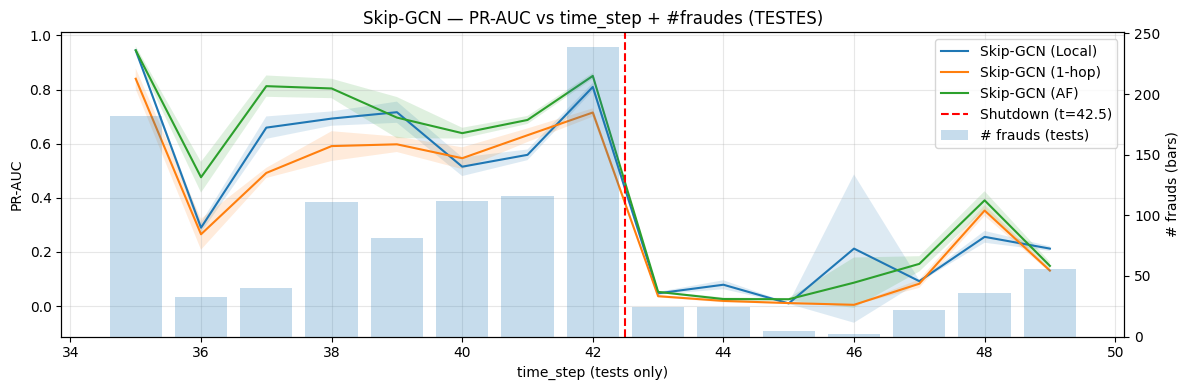

(<Figure size 1200x400 with 2 Axes>,
 <Axes: title={'center': 'Skip-GCN — PR-AUC vs time_step + #fraudes (TESTES)'}, xlabel='time_step (tests only)', ylabel='PR-AUC'>)

In [23]:
from src.utils.visualization import Visualization

Visualization.plot_pr_auc_with_fraud_bars(
    results_summary=results_summary,
    df_test1=df_test1,
    df_test2=df_test2,
    model_names=["Skip-GCN (Local)", "Skip-GCN (1-hop)", "Skip-GCN (AF)"],
    shutdown_ts=42.5,
    title="Skip-GCN — PR-AUC vs time_step + #fraudes (TESTES)",
)
